<a href="https://www.kaggle.com/code/ksenia5/comparison-of-time-series-forecasting-part-2?scriptVersionId=111268044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Part 2 - Comparison of ML methods of forecasting time series data

[In part one](https://www.kaggle.com/code/ksenia5/comparison-of-time-series-forecasting-methods-wip/) synthetic data was simulated by combining trend, seasonality, residual and autocorrelation components of time series (TS). Characterisation and transformations of TS approaches were applied to identify and remove sources of non-stationarity, needed for some forecasting methods such as the (S)ARIMA models.
<br><br>

In part two exponential smoothing, (S)ARIMA and two ML models will be used to forecast the synthetic TS data generated previously, and model performance measured and evaluated.
<br><br>

## Part 2
3. **Apply exponential smoothing and the MA/AR/ARMA statistical methods to forecast the test data.** <br>
Exponential smoothing and (S)ARIMA models, the two most common statistical models used for forecasting are compared on synthetic data. 
<br><br>
4. **Apply at least two machine leaning models to forecast the synthetic test data.**
<br><br>
5. **Measure and evaluate the performance of each method/model.** 
<br><br>
6. **[Optional] Find a suitable time series dataset (e.g., sales data, energy demand data, stock prices) and compare the forecasting performances.**
<br><br>


In [1]:
# To generate and manipulate TS data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels as ss
import math

import warnings
warnings.simplefilter(action='ignore')
%precision 3

# Statistical tests
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller

# ML libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Plotting libraries 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from colorsetup import colors, palette

# System files 
import sys
import os

# Get file paths for reading in real TS data
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

tf.random.set_seed(5) # reproducibility
print("set up complete")

/kaggle/input/syntheticts-data/synthetic_ts.csv
/kaggle/input/synthetic-ts/synthetic_ts.csv
set up complete


In [2]:
# Read in synthetic TS created in part 1
synthetic = pd.read_csv("../input/syntheticts-data/synthetic_ts.csv")
synthetic.set_index(synthetic.time,inplace=True)
#synthetic.drop(['Unnamed: 0','time'], axis=1,inplace=True)
synthetic.drop(['Unnamed: 0'], axis=1,inplace=True)
synthetic.head()
#synthetic["additive"]


,time,additive,multiplicative,autocorrelation,heteroscedastic
time,,,,,
1,1,80.14,3.57,13.84,30.0
2,2,75.65,6.78,7.29,30.0
3,3,141.13,12.56,55.95,30.0
4,4,96.69,20.31,51.19,30.0
5,5,111.83,19.24,53.64,30.0


In [3]:
# Define a plotting function
def ts_plot(x, y, title, xlabel="Time", ylabel="Value",width = 8, height = 6, label = "",y2 = None, y3 = None,):
    plt.figure(figsize=(width, height))
    plt.title(title)
    plt.plot(x, y, label=label)
    if y2 != None:
        plt.plot(y2[0], label = y2[1])
        plt.legend(loc='upper left')
    if y3 != None:
        plt.plot(y3[0], label = y3[1])
        plt.legend(loc='upper left')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show
    plt.savefig(title)

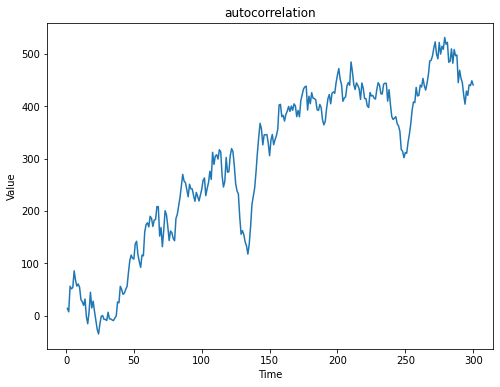

In [4]:
# name of series from synthetic dataframe
name = "autocorrelation"
ts_plot(synthetic.time, synthetic[name], name)

## 4. Apply ML to forecast TS data: LSTM and XGBoost

The **long-short term memory (LSTM)** model is implemented following [this guide ](https://www.kaggle.com/code/smrime/lstm-for-time-series-forecasting)are used to forecast portions of synthetic TS.


### Data Normalization and Train/Test Split

In [5]:
ts = synthetic[name].values.astype('float32')
ts = np.expand_dims(ts, axis = 1)


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
ts = scaler.fit_transform(ts)

# split into train and test sets
train_size = int(len(ts) * 5/6)
test_size = len(ts) - train_size
train, test = ts[0:train_size,:], ts[train_size:len(ts),:]
print(len(train), len(test))

250 50


### Array to matrix

In [6]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
# Look at train feature and target
#print(trainX)
#print(trainY)

### Create and fit the LSTM network

In [9]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

2022-11-17 10:06:03.749440: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-17 10:06:04.110174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Make predictions

In [10]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 19.51 RMSE
Test Score: 18.48 RMSE


In [11]:
# results = {"Model":["LSTM"],"Param":[{"epochs":100,"batchsize": 1,"look_back":1}],"TS":["Additive"],"TrainScore":[trainScore],"TestScore":[testScore]}
# results1 = {"Model":["LSTM"],"Param":[{"epochs":100,"batchsize": 1,"look_back":1}],"TS":["Multiplicative"],"TrainScore":[trainScore],"TestScore":[testScore]}
# results2 = {"Model":["LSTM"],"Param":[{"epochs":100,"batchsize": 1,"look_back":1}],"TS":["Autocorrelation"],"TrainScore":[trainScore],"TestScore":[testScore]}
# results3 = {"Model":["LSTM"],"Param":[{"epochs":100,"batchsize": 1,"look_back":1}],"TS":["Heteroscedastic"],"TrainScore":[trainScore],"TestScore":[testScore]}
#results3

### Plot predictions

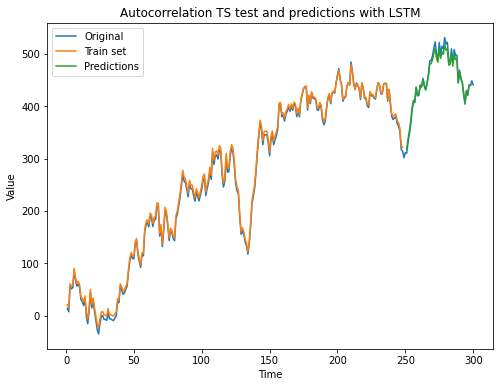

In [12]:
# shift train
trainPredictPlot = np.empty_like(ts)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(ts)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ts)-1, :] = testPredict

# plot baseline and predictions
ts_plot(synthetic.time, scaler.inverse_transform(ts), title = "Autocorrelation TS test and predictions with LSTM", label = "Original", y2= (trainPredictPlot,"Train set"),y3=(testPredictPlot,"Predictions"))
#plt.plot(trainPredictPlot, label = "Train set")
#plt.plot(testPredictPlot,label = "Predictions")
#plt.legend(loc='upper left')
plt.show()


### Extreme Gradient Boosting - XGBoost
Extreme gradient boosting [XGBoost](https://xgboost.readthedocs.io/en/latest/) is a powerful ensemble method, which uses gradient descent to add models to an ensemble used to make predictions (see this [Kaggle guide to XGBoost](https://www.kaggle.com/code/alexisbcook/xgboost)). The [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) is a python api that allows XGBoost to function like sklearn. The implementation code is adapted [from this notebook](https://www.kaggle.com/code/smrime/time-series-forecast-using-xgboost).

#### Times series data is reshaped supervised learning dataset for ML model.


In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

#### Split into train/test sets

In [14]:
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

#### Fit xgboost model and make a one step prediction

In [15]:
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]

#### Walk-forward validation

In [16]:
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		#print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

#### Apply XGBoost to make train on and predict synthetic data

In [17]:
# function that runs the test for name of column in dataframe
# plots and saves graphs
def run_XGBoost(name):
    # load the dataset
    ts = synthetic[name].values.astype('float32')
    ts = np.expand_dims(ts, axis = 1)
    # transform the time series data into supervised learning
    data = series_to_supervised(ts, n_in=6)
    # evaluate
    mae, y, yhat = walk_forward_validation(data, 50)
    # print('MAE: %.3f' % mae)

    # plot expected vs preducted
    ts_plot(np.arange(len(y)), y, "XGBoost with {} TS (zoom)".format(name),label = "Observed", y2 = (yhat,"Predicted"))

    # Add predictions to train data
    predicted = np.empty(250)
    predicted[:] = np.NaN 
    observed = np.empty(250)
    observed[:] = np.NaN 
    predicted = np.concatenate((predicted,yhat),axis=0)
    observed = np.concatenate((observed,y),axis=0)

    # calculate RMSE
    testScore = np.sqrt(mean_squared_error(observed[250:], predicted[250:]))

    # Store predictions and test score in XGboost result dictionary
    xgboost_results[name] = [observed,predicted,testScore]
    ts_plot(synthetic["time"][:250], synthetic[name][:250], "XGBoost with {} TS".format(name), label = "Observed - train", y2=(observed,"Observed - test"), y3=(predicted,"Predicted -test"))
    print("XGBoost for {} complete".format(name))

XGBoost for additive complete
XGBoost for multiplicative complete
XGBoost for autocorrelation complete
XGBoost for heteroscedastic complete


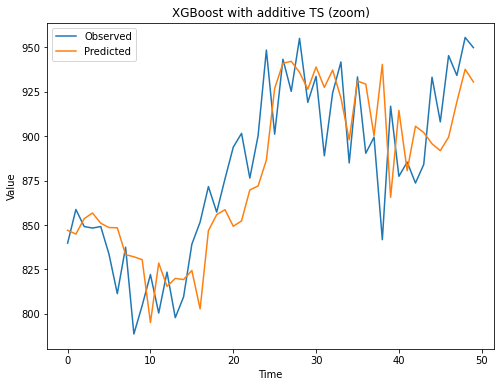

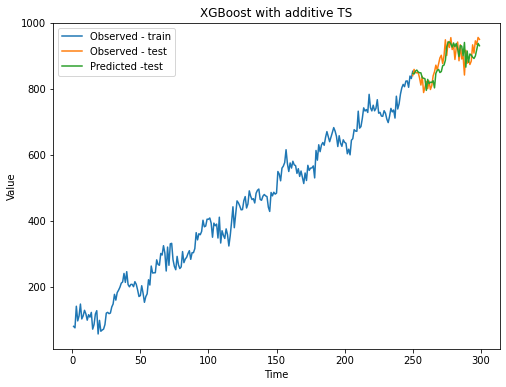

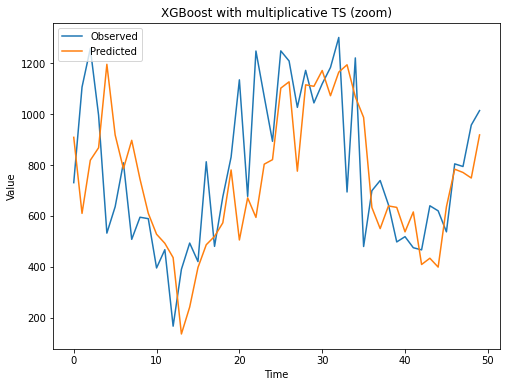

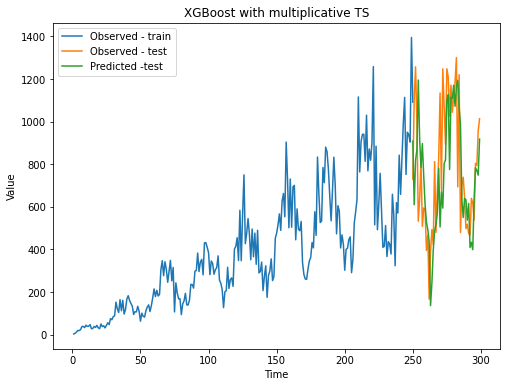

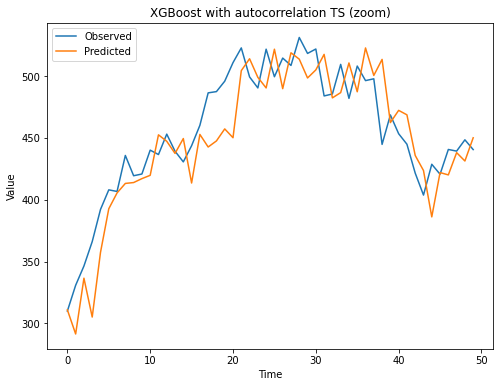

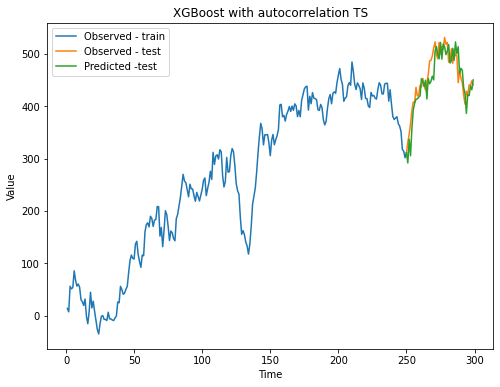

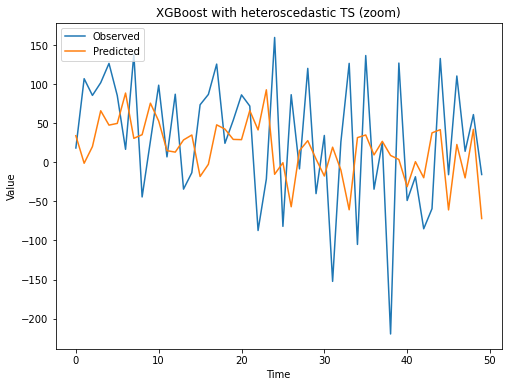

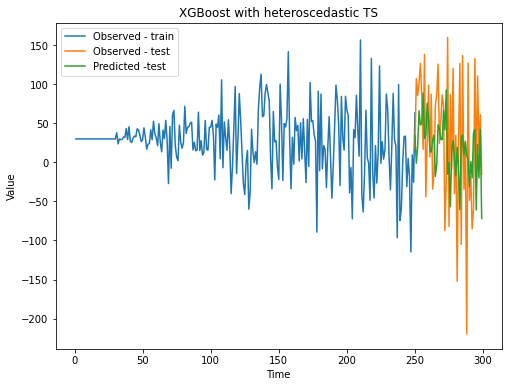

In [18]:
# Create dict to store results
xgboost_results = dict()

# Loop through dataframe columns and analyse
for name in synthetic.columns[1:]:
    run_XGBoost(name)
    
xgboost_df = pd.DataFrame(xgboost_results)
# save dataframe for plotting
xgboost_df.to_csv('xgboost_df.csv') 
    

In [19]:
xgboost_df.to_csv('xgboost_df.csv') 

## References 

* [LSTM for Time Series Forecasting](https://www.kaggle.com/code/smrime/lstm-for-time-series-forecasting)

* [Time Series Forecast using xgboost](https://www.kaggle.com/code/smrime/time-series-forecast-using-xgboost)

### Extreme gradient boosting
* [XGBoost](https://xgboost.readthedocs.io/en/latest/)